## Application of Long-Short Term Memory (LSTM) Model To Predict Apple (AAPL) Stock Price

In [2]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### Load Stock Data from Yahoo Finance

In [3]:
stock_data = yf.download('AAPL', start='2017-12-21', end='2022-12-22')
stock_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-12-21,43.542500,44.005001,43.525002,43.752499,41.604233,83799600
2017-12-22,43.669998,43.855000,43.625000,43.752499,41.604233,65397600
2017-12-26,42.700001,42.867500,42.419998,42.642502,40.548748,132742000
2017-12-27,42.525002,42.695000,42.427502,42.650002,40.555878,85992800
2017-12-28,42.750000,42.962502,42.619999,42.770000,40.669975,65920800


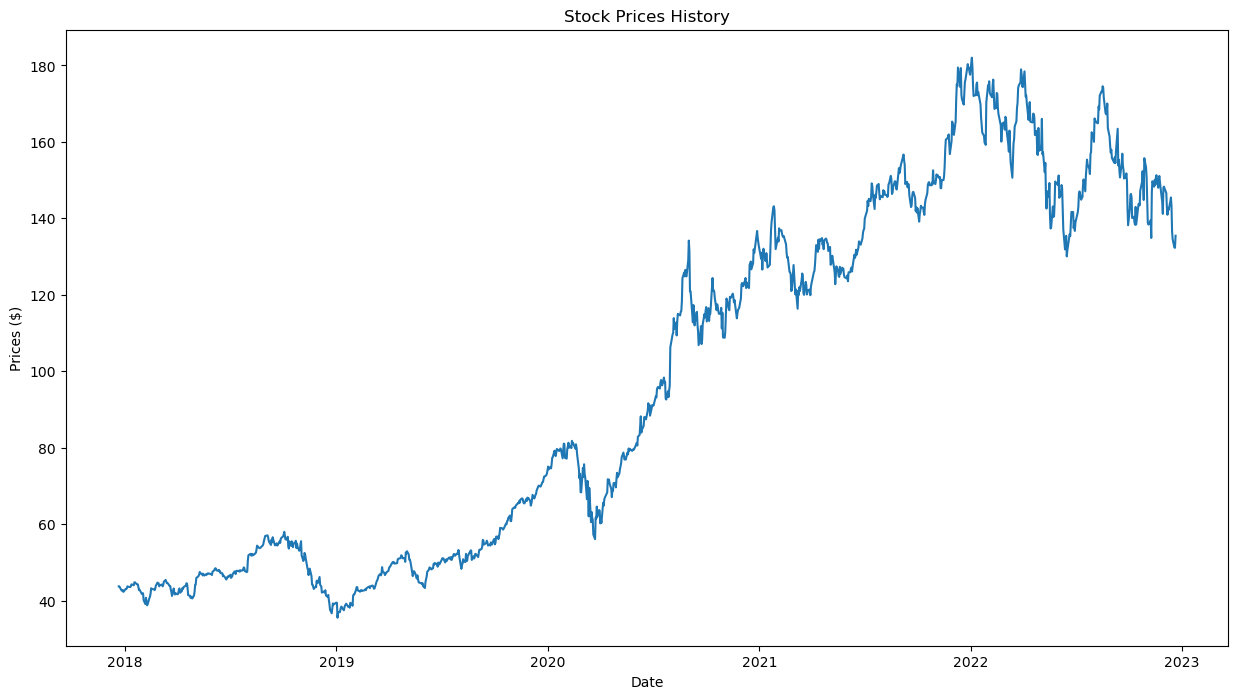

In [4]:
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(stock_data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')
plt.show()

### Split the data into training and test sets

In [5]:
close_prices = stock_data['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)


# Use the Scikit-Learn MinMaxScaler to normalize all our stock data 

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))


# Set apart the first 80% of the stock data as the training set

train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [6]:
# Testing data

test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

### Setting Up LSTM Network Architecture

In [8]:
# Define the model

model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 100)           40800     
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 25)                2525      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Training LSTM Model

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
948/948 [==============================] - 15s 14ms/step - loss: 0.0027
Epoch 2/3
948/948 [==============================] - 14s 15ms/step - loss: 0.0011
Epoch 3/3
948/948 [==============================] - 13s 14ms/step - loss: 6.6919e-04


In [10]:
# Model Evaluation

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

8/8 [==============================] - 1s 17ms/step


1.8845217883349414

### Visualizing the Predicted Prices

/var/folders/fq/2b_nnfvd72s_ks1lqr54pbc40000gn/T/ipykernel_31770/2206952766.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


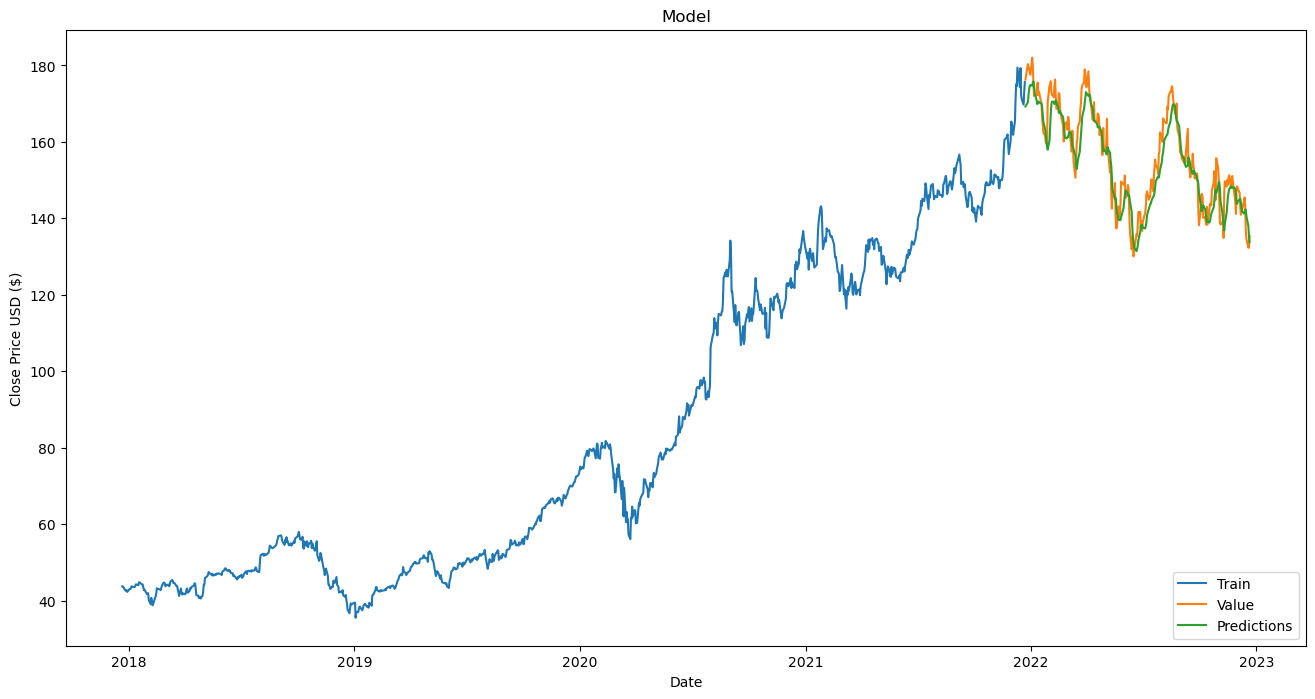

In [11]:
data = stock_data.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Value', 'Predictions'], loc='lower right')
plt.show()